# Model Tuning with Optuna

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

Hyperparameters are non-learnable parameters of a model that determine its architecture and configuration. Properly tuning
the hyperparameters of a model could mean the difference between convergence to or divergence from a
solution, e.g. choosing the proper learning rate size in a model that trains with gradient descent. In this notebook, we will explore <i>**Optuna**</i>: an open source hyperparameter optimization framework for automating hyperparameter search.

```{margin}
* [Optuna docs](https://optuna.readthedocs.io/en/stable/faq.html) 
* [Optuna FAQ](https://optuna.readthedocs.io/en/stable/index.html#) 
* [Optuna paper](https://arxiv.org/abs/1907.10902)
```

Optuna is a framework agnostic black-box optimizer. This means it only needs a real-valued objective function which returns an evaluation of the hyperparameters and it works with any machine learning or deep learning package such as scikit-learn, PyTorch, and XGBoost. Our main task as developers would be to write a suitable objective function, define the search space, and to interpret results. These correspond to manipulating the `study` and the `trial` objects as we will show in the following section.

In [3]:
import optuna
print(optuna.__version__)

# Experiment config
RF_NTRIALS = 60
VGG_NTRIALS = 40
CIFAR10_SAMPLE_RATIO = 0.5
CIFAR10_RESIZE = 32

3.0.0a2


## Basics with scikit-learn

The example below should serve as an archetype for all use-cases of Optuna. 
Observe that code for defining the search space via the `trial` object can be highly modular: 
the user can dynamically construct the search spaces for the hyperparameters within imperative Python code such as conditionals or loops, as well as 
define functions as subroutines for handling trials. Even the problem of model selection (choosing between SVM or Random Forest) 
is framed as a 
hyperparameter optimization problem. 
This is in contrast to the `GridSearchCV` 
and `RandomSearchCV` APIs in scikit-learn where we had to define the entire 
search space before running the search algorithm for a single model.

In [4]:
import pandas as pd
from sklearn import ensemble, svm
from sklearn import datasets
from sklearn import model_selection
from functools import partial
import joblib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # https://github.com/optuna/optuna/releases/tag/v3.0.0-a1


# (1) Define an objective function to be maximized.
def objective(trial, X, y):
    
    # (2) Suggest values for the hyperparameters using trial object.
    clf_name = trial.suggest_categorical('classifier', ['SVC', 'RandomForest'])
    if clf_name == 'SVC':
        svc_c = trial.suggest_float('svc_c', 1e-10, 1e10, log=True)
        clf = svm.SVC(C=svc_c, gamma='auto')
    else:
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
        clf = ensemble.RandomForestClassifier(max_depth=rf_max_depth, n_estimators=10)

    # Always cross-validate!
    score = model_selection.cross_val_score(clf, X, y, n_jobs=-1, cv=5)
    return score.mean()

# (3) Create a study object and optimize the objective function.
X, y = datasets.load_breast_cancer(return_X_y=True)
study = optuna.create_study(direction="maximize")
study.optimize(partial(objective, X=X, y=y), n_trials=5, n_jobs=-1)

[I 2022-03-29 05:49:19,400] A new study created in memory with name: no-name-db4d1464-6be9-4b89-8b54-9ff08d7bad92
[I 2022-03-29 05:49:20,516] Trial 1 finished with value: 0.6274181027790716 and parameters: {'classifier': 'SVC', 'svc_c': 1.9922389105979842e-09}. Best is trial 1 with value: 0.6274181027790716.
[I 2022-03-29 05:49:20,541] Trial 0 finished with value: 0.6274181027790716 and parameters: {'classifier': 'SVC', 'svc_c': 2.9385606975026297e-09}. Best is trial 1 with value: 0.6274181027790716.
[I 2022-03-29 05:49:20,740] Trial 2 finished with value: 0.956078248719143 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 5}. Best is trial 2 with value: 0.956078248719143.
[I 2022-03-29 05:49:20,754] Trial 3 finished with value: 0.9455364073901567 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 4}. Best is trial 2 with value: 0.956078248719143.
[I 2022-03-29 05:49:20,845] Trial 4 finished with value: 0.9490451793199813 and parameters: {'classifier': 'RandomF

The result of each trial can be accessed in the study object:

In [5]:
study.trials_dataframe().head()

,number,value,datetime_start,datetime_complete,duration,params_classifier,params_rf_max_depth,params_svc_c,state
0,0,0.627418,2022-03-29 05:49:19.404269,2022-03-29 05:49:20.541145,0 days 00:00:01.136876,SVC,NaN,2.938561e-09,COMPLETE
1,1,0.627418,2022-03-29 05:49:19.408069,2022-03-29 05:49:20.515667,0 days 00:00:01.107598,SVC,NaN,1.992239e-09,COMPLETE
2,2,0.956078,2022-03-29 05:49:20.521504,2022-03-29 05:49:20.740331,0 days 00:00:00.218827,RandomForest,5.0,NaN,COMPLETE
3,3,0.945536,2022-03-29 05:49:20.545865,2022-03-29 05:49:20.753829,0 days 00:00:00.207964,RandomForest,4.0,NaN,COMPLETE
4,4,0.949045,2022-03-29 05:49:20.745194,2022-03-29 05:49:20.845302,0 days 00:00:00.100108,RandomForest,32.0,NaN,COMPLETE


### Fine tuning Random Forest

Here we focus on tuning a single Random Forest model. Then, plot the accuracy for each pair of hyperparameters.

In [6]:
def objective(trial):
    
    max_depth = trial.suggest_int('max_depth', 2, 128, log=True)    
    max_features = trial.suggest_float('max_features', 0.1, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 100, 800, log=True)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    clf = ensemble.RandomForestClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        max_features=max_features,
        criterion=criterion,
        random_state=42)   
    
    score = model_selection.cross_val_score(clf, X, y, n_jobs=-1, cv=5)
    return score.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=RF_NTRIALS, n_jobs=-1)

[I 2022-03-29 05:49:20,893] A new study created in memory with name: no-name-4432a1a2-3048-489e-9eb1-cbb932038608
[I 2022-03-29 05:49:27,847] Trial 0 finished with value: 0.95960254618848 and parameters: {'max_depth': 13, 'max_features': 0.5094176098270098, 'n_estimators': 125, 'criterion': 'entropy'}. Best is trial 0 with value: 0.95960254618848.
[I 2022-03-29 05:49:29,586] Trial 1 finished with value: 0.9648657040832169 and parameters: {'max_depth': 4, 'max_features': 0.3088112226520346, 'n_estimators': 642, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9648657040832169.
[I 2022-03-29 05:49:30,058] Trial 2 finished with value: 0.9578481602235678 and parameters: {'max_depth': 10, 'max_features': 0.10310188914369661, 'n_estimators': 172, 'criterion': 'gini'}. Best is trial 1 with value: 0.9648657040832169.
[I 2022-03-29 05:49:36,248] Trial 3 finished with value: 0.968390001552554 and parameters: {'max_depth': 5, 'max_features': 0.7519175565437778, 'n_estimators': 228, 'criteri

In [7]:
study.best_params

{'max_depth': 5,
 'max_features': 0.7519175565437778,
 'n_estimators': 228,
 'criterion': 'entropy'}

In [8]:
study.best_value

0.968390001552554

### Sampling algorithms

Optuna uses  **Tree-structured Parzen Estimater** (**TPE**) {cite}`bergstra` as the default sampler which is a form of Bayesian optimization. Observe that the hyperparameter space is searched more efficiently than random search with the sampler choosing points closer to previous good results. Samplers are specified when creating a study: 

```python
study = create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
```

TPE samples every hyperparameter independently. From the [docs](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html#optuna.samplers.TPESampler):

> On each trial, for each parameter, TPE fits one Gaussian Mixture Model (GMM) `l(x)` to the set of parameter values associated with the best objective values, and another GMM `g(x)` to the remaining parameter values. It chooses the parameter value `x` that maximizes the ratio `l(x)/g(x)`.

The following plot shows the difference between TPE with grid and random sampling:

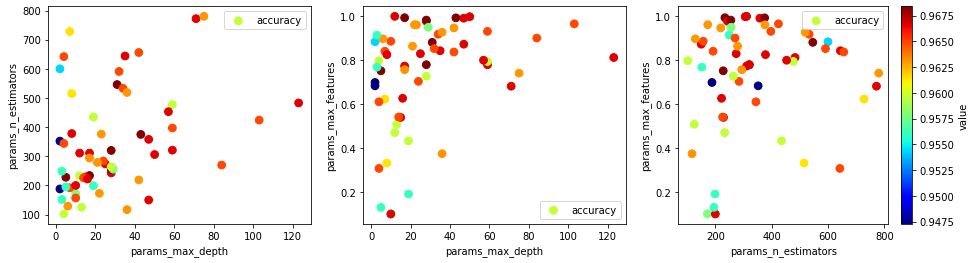

In [9]:
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
fig, axes = plt.subplots(nrows=1, ncols=3)

def plot_results(study, p1, p2, j, cb):
    study.trials_dataframe().plot(
        kind='scatter', ax=axes[j], x=p1, y=p2,
        c='value', s=60, cmap=plt.get_cmap("jet"), 
        colorbar=cb, label="accuracy", figsize=(16, 4)
    )

plot_results(study, 'params_max_depth',    'params_n_estimators', j=0, cb=False)
plot_results(study, 'params_max_depth',    'params_max_features', j=1, cb=False)
plot_results(study, 'params_n_estimators', 'params_max_features', j=2, cb=True);

$ $

```{figure} ../../img/optuna-samplers.png
---
name: optuna-samplers
---
List of all [sampling algorithms](https://optuna.readthedocs.io/en/stable/reference/samplers.html) as of version 2.10.0.
```

Another sampling algorithm implemented is **Covariance Matrix Adaptation Evolution Strategy** (**CMA-ES**) {cite}`hansen2016cma`. This algorithm is designed to tackle ill-conditioned, non-separable problems, i.e. cannot be solved by solving several 1-dimensional problems. CMA-ES is typically implemented along with TPE whenever the former algorithm is not applicable, e.g. for searching dynamically constructed hyperparameters (as CMA-ES requires that parameters are specified statically prior to the optimization) or for searching categorical parameters, as CMA-ES is designed to search real parameters on a continuous domain. TPE + CMA-ES sampling can be implemented as follows:

```python
sampler = optuna.samplers.CmaEsSampler(
    warn_independent_sampling=False,
    independent_sampler=optuna.samplers.TPESampler()
)
```

Results from the paper {cite}`akiba2019optuna` show that TPE + CMA-ES works better than counterparts of the same time complexity:

```{figure} ../../img/fig9-optuna.png
---
width: 35em
name: fig9-optuna
---
```

```{figure} ../../img/fig10-optuna.png
---
width: 35em
name: fig10-optuna
---
```

## Results visualization

**History.** Optuna provides visualization functions in the `optuna.visualization` library[^ref4]. The following plot shows the best objective value found as the trials progress. The increasing trend in accuracy indicates that the TPE sampler is working well, i.e. the search algorithm learns from previous trials.

[^ref4]: The plots are displayed in SVG format due to technical difficulties. Running them locally with the default renderer results in [interactive plotly plots](https://plotly.com/python/getting-started/).

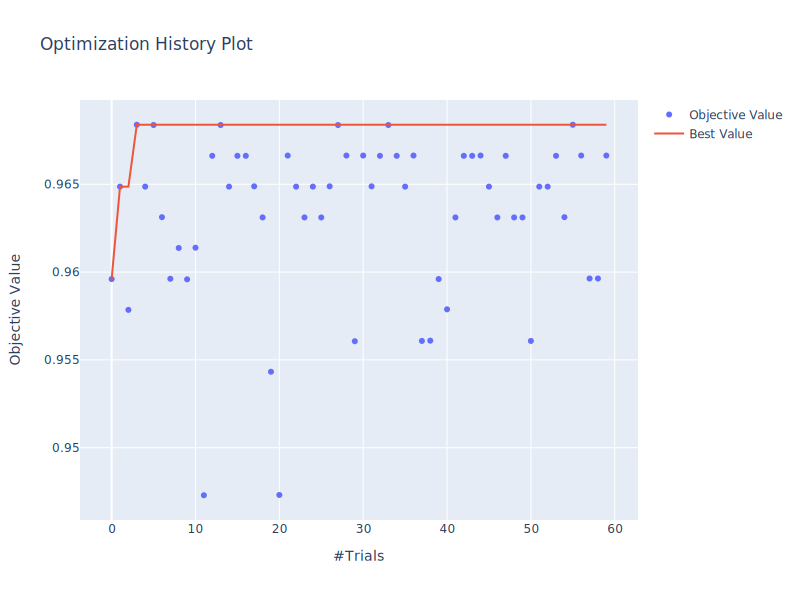

In [10]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show(renderer="svg")

**Parallel coordinate plot.** The parallel coordinate plot gives us a feel of how the hyperparameters interact. To isolate subsets of lines, we can use the interactive capabilities of the plots by dragging on each axis to restrict it. The resulting purple bars can be disjoint.

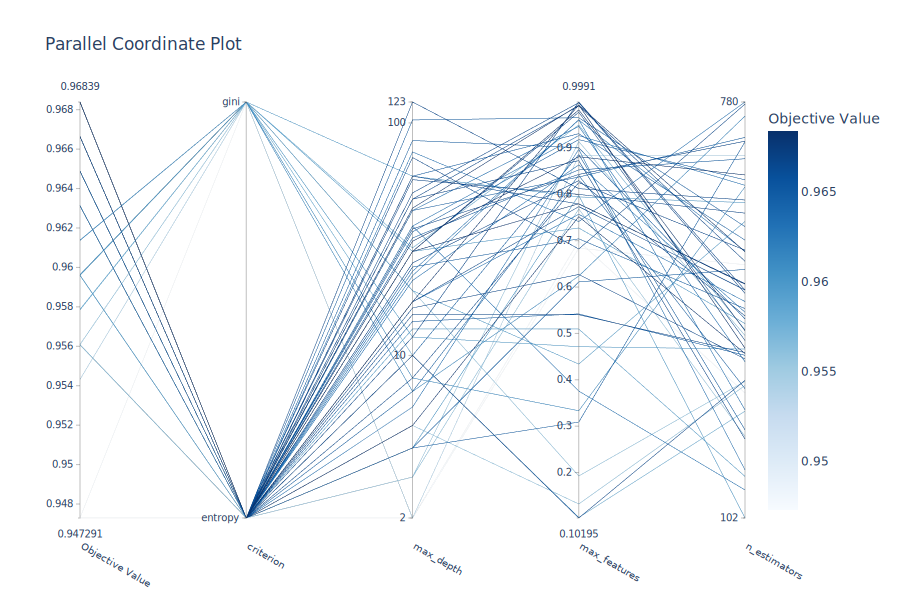

In [11]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=900, height=600)
fig.show(renderer="svg")

**Slice plots.** Slice plots show the projections of the sampler's path in the hyperparameter space in each individual dimension, then shifts each point along the vertical axis based on the its objective value. 

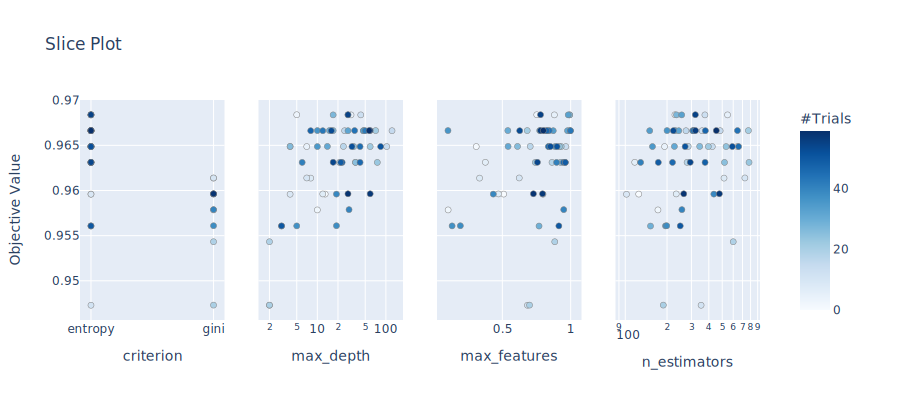

In [15]:
fig = optuna.visualization.plot_slice(study)
fig.update_layout(width=900, height=400)
fig.show(renderer="svg")

**Hyperparameter importance.** The default importance evaluator in Optuna is `FanovaImportanceEvaluator`. This takes as input performance data gathered with different hyperparameter settings of the algorithm, fits a random forest to capture the relationship between hyperparameters and performance, and then applies functional ANOVA to assess how important each of the hyperparameters and each low-order interaction of hyperparameters is to performance {cite}`pmlr-v32-hutter14`. From the [docs](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.importance.FanovaImportanceEvaluator.html):

> The performance of fANOVA depends on the prediction performance of the underlying random forest model. In order to obtain high prediction performance, it is necessary to cover a wide range of the hyperparameter search space. It is recommended to use an exploration-oriented sampler such as `RandomSampler`.

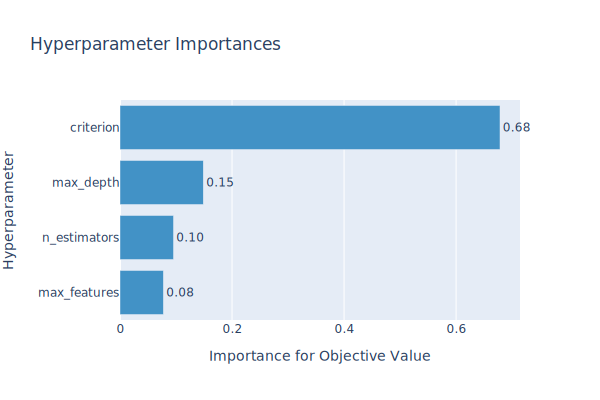

In [16]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(width=600, height=400)
fig.show(renderer="svg")

**Contour plots.** To visualize interactions between any pair of hyperparameters spatially, we can generate contour plots where regions of *low* objective value are darker in color.

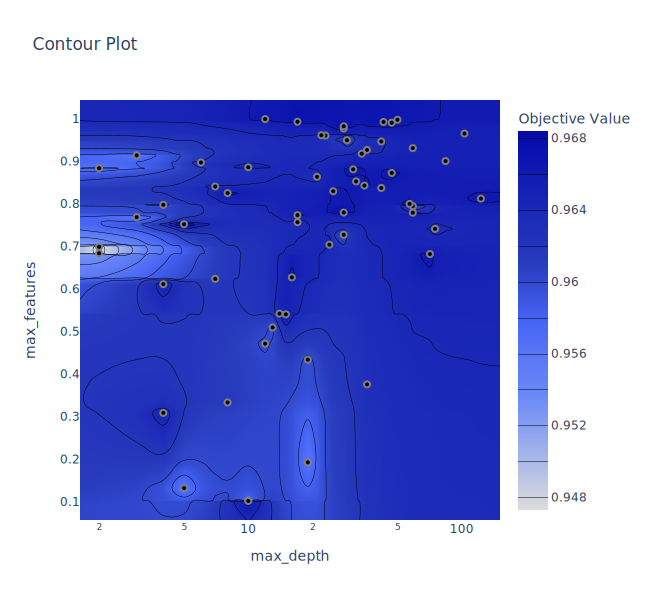

In [17]:
fig = optuna.visualization.plot_contour(study, params=["max_depth", "max_features"])
fig.update_layout(width=650, height=600)
fig.show(renderer="svg")

## Neural networks

As noted above, we should always perform tuning within a cross-validation framework. However, with neural networks, doing 5-fold CV would require too much compute time &mdash; hence, too much resources, e.g. GPU usage. Instead, we perform tuning on a hold-out validation set and hope for the best. 

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils import data

from tqdm.notebook import tqdm
import optuna
import numpy as np

PATIENCE = 5
EPOCHS = 100
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Define a convolutional network with a smaller version of the VGG architecture.

In [19]:
# https://d2l.ai/chapter_convolutional-modern/vgg.html

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)


def vgg(conv_arch, linear_width, dropout, in_channels=3):
    conv_blks = []
    # The convolutional part
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    height, width = 6, 6
    dense_layers = [
        nn.AdaptiveAvgPool2d((height, width)),
        nn.Flatten(),
        nn.Linear(out_channels * height * width, linear_width),
        nn.ReLU(), nn.Dropout(dropout),
        nn.Linear(linear_width, linear_width),
        nn.ReLU(), nn.Dropout(dropout),
        nn.Linear(linear_width, 10)
    ]
    return nn.Sequential(*(conv_blks + dense_layers))

We also define a `Dataset` class for CIFAR-10.

In [20]:
transform = [transforms.ToTensor()]
if CIFAR10_RESIZE:
    transform.insert(0, transforms.Resize(CIFAR10_RESIZE))
transform = transforms.Compose(transform)

mnist_train = datasets.CIFAR10(root=".", train=True,  transform=transform, download=True)
mnist_valid = datasets.CIFAR10(root=".", train=False, transform=transform, download=True)


def get_cifar10_dataloaders(batch_size, resize, sample_ratio=1.0):
    train_loader = data.DataLoader(mnist_train, 
                                   batch_size, 
                                   drop_last=True, 
                                   sampler=range(int(len(mnist_train)*sample_ratio)))
    
    valid_loader = data.DataLoader(mnist_valid, 
                                   batch_size, 
                                   drop_last=True, 
                                   sampler=range(int(len(mnist_valid)*sample_ratio)))
    
    return train_loader, valid_loader

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


Define a trainer for the neural network model. This will handle all loss and metric evaluation, as well as backpropagation.

In [21]:
class Engine:
    """Facilitate neural network training and evaluation."""
    
    def __init__(self, model, device, optimizer):
        self.model = model
        self.device = device
        self.optimizer = optimizer 

    @staticmethod
    def loss_fn(outputs, targets):
        return nn.CrossEntropyLoss()(outputs, targets)
        
    def train(self, data_loader):
        """Train model on one epoch. Return train loss."""
        
        self.model.train()
        loss = 0
        for i, (data, targets) in enumerate(data_loader):
            data = data.to(self.device).float()
            targets = targets.to(self.device).long()
            
            # Forward pass
            outputs = self.model(data)
            J = self.loss_fn(outputs, targets)
            
            # Backward pass
            self.optimizer.zero_grad()
            J.backward()
            self.optimizer.step()

            # Cumulative loss
            loss += (J.detach().item() - loss) / (i + 1)

        return loss


    def eval(self, data_loader):
        """Return validation loss and validation accuracy."""
        
        self.model.eval()
        num_correct = 0
        num_samples = 0
        loss = 0.0
        with torch.no_grad():
            for i, (data, targets) in enumerate(data_loader):
                data = data.to(self.device).float()
                targets = targets.to(self.device)
                
                # Forward pass
                out = self.model(data)
                J = self.loss_fn(out, targets)
                _, preds = out.max(dim=1)

                # Cumulative metrics
                loss += (J.detach().item() - loss) / (i + 1)
                num_correct += (preds == targets).sum().item()
                num_samples += preds.shape[0]

        acc = num_correct / num_samples
        return loss, acc

### Pruning trials based on intermediate values

Finally, we set up the `study` instance and its objective function. Note that the search space is dynamically constructed depending on the number of layers (i.e. an earlier suggestion for a hyperparameter). During training, we perform early stopping on validation loss. If no new minimum val. loss is found after 5 epochs, then the minimum val. loss is returned as the objective[^ref3].

Computing intermediate values allow us to **prune** unpromising trials to conserve resources. The default pruner in Optuna is [`MedianPruner`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.MedianPruner.html) which prunes a trial if its best intermediate result as of the current step (e.g. current best valid loss) is worse than the median of all intermediate results of previous trials *at the current step*. Hence, the best intermediate result of a pruned trial is less than the best intermediate result of 1/2 of the other trials as of that step. In our case, if the minimum validation loss does not improve too quickly, then the trial is pruned. Of course, the validation loss could descend rapidly at later steps, but the median pruner does not bet on this happening.

[^ref3]: In practice, we save the best model parameters at this point.

In [24]:
def run_training(trial, train_loader, valid_loader, engine):
    # Run training
    best_loss = np.inf
    patience = PATIENCE
    loop = tqdm(range(EPOCHS), total=EPOCHS, leave=False)
    for epoch in loop:

        # Train and validation step
        train_loss = engine.train(train_loader)
        valid_loss, valid_acc = engine.eval(valid_loader)
            
        # Early stopping
        if valid_loss < best_loss:
            best_loss = valid_loss
            patience = PATIENCE
        else:
            patience -= 1
            if patience == 0:
                break
    
        # Pruning unpromising trials
        trial.report(valid_loss, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(
            val_loss=valid_loss, 
            acc=valid_acc, 
            patience=patience,
            lr=engine.optimizer.param_groups[0]['lr'])
        
    return best_loss


def objective(trial):
    # Setup model architecture
    conv_arch = [
        (1, trial.suggest_int(f"vgg_b1", 128, 512, log=True)),
        (2, trial.suggest_int(f"vgg_b2", 128, 512, log=True)),
        (2, trial.suggest_int(f"vgg_b3", 128, 512, log=True)),
    ]
    dense_width = trial.suggest_int("dense", 256, 1024, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 1.0, step=0.1)
    learning_rate = trial.suggest_float("lr", 1e-5, 0.3, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 128, log=True)

    # Initialize engine
    model = vgg(conv_arch, dense_width, dropout).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)    
    engine = Engine(model, DEVICE, optimizer)
    
    # Initalize data loaders
    train_loader, valid_loader = get_cifar10_dataloaders(batch_size, resize=28, sample_ratio=CIFAR10_SAMPLE_RATIO)
    
    # Start training run
    score = run_training(trial, train_loader, valid_loader, engine)
    return score

This study looks rather complicated, with a lot of moving parts. We can test the objective using a `FixedTrial` which suggests fixed parameter values based on a given dictionary of parameters:

```python
trial = FixedTrial(param_dict)
objective(trial) 
```

Running the minimization problem with `MedianPruner`. The parameters of the pruner will be explained below.

In [25]:
pruner = optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=15, n_min_trials=5)
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=VGG_NTRIALS, n_jobs=-1)

[I 2022-03-29 05:56:29,769] A new study created in memory with name: no-name-7a289cf4-0c0a-4863-85b9-9ad2a39a5da3


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 06:01:01,693] Trial 0 finished with value: 2.316252053607994 and parameters: {'vgg_b1': 364, 'vgg_b2': 232, 'vgg_b3': 226, 'dense': 294, 'dropout': 0.8, 'lr': 0.08796261436213096, 'batch_size': 23}. Best is trial 0 with value: 2.316252053607994.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 06:02:59,187] Trial 1 finished with value: 1.013104486019433 and parameters: {'vgg_b1': 358, 'vgg_b2': 429, 'vgg_b3': 243, 'dense': 471, 'dropout': 0.1, 'lr': 0.00037818973842870097, 'batch_size': 34}. Best is trial 1 with value: 1.013104486019433.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 06:05:37,313] Trial 3 finished with value: 2.3039556230817517 and parameters: {'vgg_b1': 504, 'vgg_b2': 275, 'vgg_b3': 174, 'dense': 273, 'dropout': 0.8, 'lr': 0.018555785345731025, 'batch_size': 89}. Best is trial 1 with value: 1.013104486019433.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 06:10:45,462] Trial 2 finished with value: 0.9313148994897976 and parameters: {'vgg_b1': 427, 'vgg_b2': 509, 'vgg_b3': 356, 'dense': 346, 'dropout': 0.2, 'lr': 5.56165039904537e-05, 'batch_size': 43}. Best is trial 2 with value: 0.9313148994897976.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 06:13:22,302] Trial 4 finished with value: 1.0084284386584457 and parameters: {'vgg_b1': 433, 'vgg_b2': 398, 'vgg_b3': 428, 'dense': 591, 'dropout': 0.5, 'lr': 0.000528391956405014, 'batch_size': 35}. Best is trial 2 with value: 0.9313148994897976.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 06:15:13,956] Trial 5 finished with value: 2.319244773299605 and parameters: {'vgg_b1': 133, 'vgg_b2': 208, 'vgg_b3': 315, 'dense': 967, 'dropout': 0.30000000000000004, 'lr': 0.1590032094640455, 'batch_size': 46}. Best is trial 2 with value: 0.9313148994897976.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 06:17:20,709] Trial 7 finished with value: 2.302876393000285 and parameters: {'vgg_b1': 226, 'vgg_b2': 204, 'vgg_b3': 245, 'dense': 618, 'dropout': 0.7000000000000001, 'lr': 0.009413255560568766, 'batch_size': 127}. Best is trial 2 with value: 0.9313148994897976.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 06:17:23,146] Trial 6 finished with value: 2.3103526428844154 and parameters: {'vgg_b1': 451, 'vgg_b2': 274, 'vgg_b3': 156, 'dense': 452, 'dropout': 0.7000000000000001, 'lr': 0.05088166598995448, 'batch_size': 28}. Best is trial 2 with value: 0.9313148994897976.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 06:19:45,462] Trial 9 finished with value: 2.3064239837906575 and parameters: {'vgg_b1': 152, 'vgg_b2': 291, 'vgg_b3': 231, 'dense': 730, 'dropout': 0.7000000000000001, 'lr': 0.09125708904050722, 'batch_size': 113}. Best is trial 2 with value: 0.9313148994897976.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 06:25:01,791] Trial 10 finished with value: 1.0533342144706033 and parameters: {'vgg_b1': 201, 'vgg_b2': 142, 'vgg_b3': 172, 'dense': 692, 'dropout': 0.8, 'lr': 0.000996510894859714, 'batch_size': 113}. Best is trial 2 with value: 0.9313148994897976.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 06:31:17,986] Trial 8 finished with value: 2.3026085709914184 and parameters: {'vgg_b1': 334, 'vgg_b2': 444, 'vgg_b3': 200, 'dense': 577, 'dropout': 0.7000000000000001, 'lr': 0.00037459233700737105, 'batch_size': 32}. Best is trial 2 with value: 0.9313148994897976.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 06:52:27,916] Trial 12 finished with value: 0.8811799085140226 and parameters: {'vgg_b1': 288, 'vgg_b2': 499, 'vgg_b3': 500, 'dense': 387, 'dropout': 0.4, 'lr': 2.0136577114284386e-05, 'batch_size': 50}. Best is trial 12 with value: 0.8811799085140226.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 07:01:11,039] Trial 11 finished with value: 0.9711254999901239 and parameters: {'vgg_b1': 302, 'vgg_b2': 480, 'vgg_b3': 505, 'dense': 355, 'dropout': 0.1, 'lr': 1.5001965117390995e-05, 'batch_size': 16}. Best is trial 12 with value: 0.8811799085140226.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 07:22:57,323] Trial 13 finished with value: 0.8948011627030928 and parameters: {'vgg_b1': 281, 'vgg_b2': 502, 'vgg_b3': 506, 'dense': 356, 'dropout': 0.30000000000000004, 'lr': 1.2559454185870841e-05, 'batch_size': 58}. Best is trial 12 with value: 0.8811799085140226.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 07:31:35,969] Trial 14 finished with value: 0.9343924910523173 and parameters: {'vgg_b1': 266, 'vgg_b2': 351, 'vgg_b3': 335, 'dense': 369, 'dropout': 0.4, 'lr': 1.5342748829780214e-05, 'batch_size': 58}. Best is trial 12 with value: 0.8811799085140226.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 07:32:01,407] Trial 15 pruned. 


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 07:39:44,372] Trial 17 pruned. 


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 07:40:33,812] Trial 16 finished with value: 0.8866717630708719 and parameters: {'vgg_b1': 187, 'vgg_b2': 347, 'vgg_b3': 487, 'dense': 420, 'dropout': 0.4, 'lr': 8.465099244708627e-05, 'batch_size': 70}. Best is trial 12 with value: 0.8811799085140226.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 07:48:07,560] Trial 19 finished with value: 0.8862666321582481 and parameters: {'vgg_b1': 183, 'vgg_b2': 392, 'vgg_b3': 128, 'dense': 429, 'dropout': 0.5, 'lr': 0.00010595241532158906, 'batch_size': 81}. Best is trial 12 with value: 0.8811799085140226.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 07:48:56,255] Trial 18 finished with value: 0.8876643880553865 and parameters: {'vgg_b1': 291, 'vgg_b2': 155, 'vgg_b3': 298, 'dense': 439, 'dropout': 0.30000000000000004, 'lr': 7.92154723361856e-05, 'batch_size': 54}. Best is trial 12 with value: 0.8811799085140226.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 07:51:55,077] Trial 20 finished with value: 2.302641837685197 and parameters: {'vgg_b1': 162, 'vgg_b2': 135, 'vgg_b3': 137, 'dense': 510, 'dropout': 0.5, 'lr': 0.002573859740446051, 'batch_size': 91}. Best is trial 12 with value: 0.8811799085140226.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 07:55:06,501] Trial 21 finished with value: 2.302688035097989 and parameters: {'vgg_b1': 164, 'vgg_b2': 403, 'vgg_b3': 129, 'dense': 527, 'dropout': 0.5, 'lr': 0.003535472267373363, 'batch_size': 90}. Best is trial 12 with value: 0.8811799085140226.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 07:58:48,849] Trial 22 finished with value: 0.8941466410954795 and parameters: {'vgg_b1': 183, 'vgg_b2': 397, 'vgg_b3': 425, 'dense': 423, 'dropout': 0.4, 'lr': 0.0001658684650550255, 'batch_size': 79}. Best is trial 12 with value: 0.8811799085140226.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 08:01:39,865] Trial 23 finished with value: 0.9267186846051896 and parameters: {'vgg_b1': 224, 'vgg_b2': 312, 'vgg_b3': 428, 'dense': 415, 'dropout': 0.4, 'lr': 0.00014031598587285684, 'batch_size': 71}. Best is trial 12 with value: 0.8811799085140226.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 08:05:07,802] Trial 24 pruned. 


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 08:09:48,482] Trial 25 pruned. 


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 08:12:53,749] Trial 26 pruned. 


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 08:15:50,025] Trial 27 finished with value: 0.9048153119087218 and parameters: {'vgg_b1': 134, 'vgg_b2': 374, 'vgg_b3': 458, 'dense': 488, 'dropout': 0.30000000000000004, 'lr': 0.0001476572944160441, 'batch_size': 40}. Best is trial 12 with value: 0.8811799085140226.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 08:18:50,224] Trial 28 finished with value: 0.9440316341351718 and parameters: {'vgg_b1': 185, 'vgg_b2': 376, 'vgg_b3': 463, 'dense': 498, 'dropout': 0.2, 'lr': 0.00016912119734762215, 'batch_size': 39}. Best is trial 12 with value: 0.8811799085140226.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 08:19:54,004] Trial 29 finished with value: 1.086020887682313 and parameters: {'vgg_b1': 187, 'vgg_b2': 421, 'vgg_b3': 268, 'dense': 389, 'dropout': 0.2, 'lr': 0.0009947891959525377, 'batch_size': 65}. Best is trial 12 with value: 0.8811799085140226.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 08:24:07,526] Trial 30 finished with value: 1.081628870505553 and parameters: {'vgg_b1': 153, 'vgg_b2': 240, 'vgg_b3': 268, 'dense': 398, 'dropout': 0.5, 'lr': 0.0010766573035746946, 'batch_size': 64}. Best is trial 12 with value: 0.8811799085140226.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 08:30:39,562] Trial 32 finished with value: 0.8700614416080973 and parameters: {'vgg_b1': 306, 'vgg_b2': 174, 'vgg_b3': 352, 'dense': 449, 'dropout': 0.30000000000000004, 'lr': 9.153843325718859e-05, 'batch_size': 54}. Best is trial 32 with value: 0.8700614416080973.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 08:36:52,543] Trial 33 pruned. 


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 08:39:32,841] Trial 31 finished with value: 0.8902921310663222 and parameters: {'vgg_b1': 324, 'vgg_b2': 257, 'vgg_b3': 361, 'dense': 555, 'dropout': 0.5, 'lr': 2.7921317122125132e-05, 'batch_size': 20}. Best is trial 32 with value: 0.8700614416080973.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 08:41:05,808] Trial 34 finished with value: 0.9589584899730369 and parameters: {'vgg_b1': 386, 'vgg_b2': 175, 'vgg_b3': 199, 'dense': 459, 'dropout': 0.30000000000000004, 'lr': 0.00034718748555983105, 'batch_size': 81}. Best is trial 32 with value: 0.8700614416080973.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 08:45:24,073] Trial 35 finished with value: 0.9580405403356084 and parameters: {'vgg_b1': 389, 'vgg_b2': 177, 'vgg_b3': 206, 'dense': 459, 'dropout': 0.2, 'lr': 0.00027177652407138996, 'batch_size': 81}. Best is trial 32 with value: 0.8700614416080973.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 08:52:40,663] Trial 36 finished with value: 0.9425479064182358 and parameters: {'vgg_b1': 249, 'vgg_b2': 468, 'vgg_b3': 464, 'dense': 469, 'dropout': 0.1, 'lr': 8.340984637665178e-05, 'batch_size': 102}. Best is trial 32 with value: 0.8700614416080973.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 08:54:21,369] Trial 37 pruned. 


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 09:00:47,815] Trial 39 finished with value: 1.0189804366204587 and parameters: {'vgg_b1': 312, 'vgg_b2': 507, 'vgg_b3': 150, 'dense': 631, 'dropout': 0.4, 'lr': 0.0006578090901232402, 'batch_size': 44}. Best is trial 32 with value: 0.8700614416080973.
[I 2022-03-29 09:02:58,766] Trial 38 finished with value: 0.9041590550998312 and parameters: {'vgg_b1': 311, 'vgg_b2': 223, 'vgg_b3': 339, 'dense': 324, 'dropout': 0.4, 'lr': 5.229926907878646e-05, 'batch_size': 45}. Best is trial 32 with value: 0.8700614416080973.


In [75]:
from optuna.trial import TrialState

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials:\t", len(study.trials))
print("  Number of pruned trials:\t", len(pruned_trials))
print("  Number of complete trials:\t", len(complete_trials))

print("\nBest trial:")
best_trial = study.best_trial

print("  Number:", best_trial.number)
print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:	 40
  Number of pruned trials:	 7
  Number of complete trials:	 33

Best trial:
  Number: 32
  Value:  0.8700614416080973
  Params: 
    vgg_b1: 306
    vgg_b2: 174
    vgg_b3: 352
    dense: 449
    dropout: 0.30000000000000004
    lr: 9.153843325718859e-05
    batch_size: 54


Let's compare this some hand-designed network that resembles the [VGG architecture](https://d2l.ai/chapter_convolutional-modern/vgg.html#vgg-network). The result is pretty bad.

In [71]:
param_dict = {
    "vgg_b1": 64,
    "vgg_b2": 128,
    "vgg_b3": 256,
    "dense": 1024,
    "dropout": 0.5,
    "lr": 0.1,
    "batch_size": 32
}

trial = optuna.trial.FixedTrial(param_dict)
objective(trial) 

  0%|          | 0/100 [00:00<?, ?it/s]

2.3142308332981214

Trials either early stops (gradient descent loses momentum) or gets pruned (expected to not improve even if gradient descent continues). Pruning starts after 10 trials are completed, i.e. `n_startup_trials=10`. This is so that the pruner obtains enough information about the general behavior of the gradient descent optimizer before starting to prune. 

We set `n_warmup_steps=15` allowing each trial to train the network for 16 epochs before pruning, so that the completed trials will not be dominated by networks that descend quickly, but to shallow minimas. For example, shallow networks that possibly overfits the validation set. However, this comes at the price of wasting resources for training 16 epochs for around half of the number of trials. Finally, we set `n_min_trials=5` so that a higher number of trials at later steps can continue until it early stops or reaches max epochs.

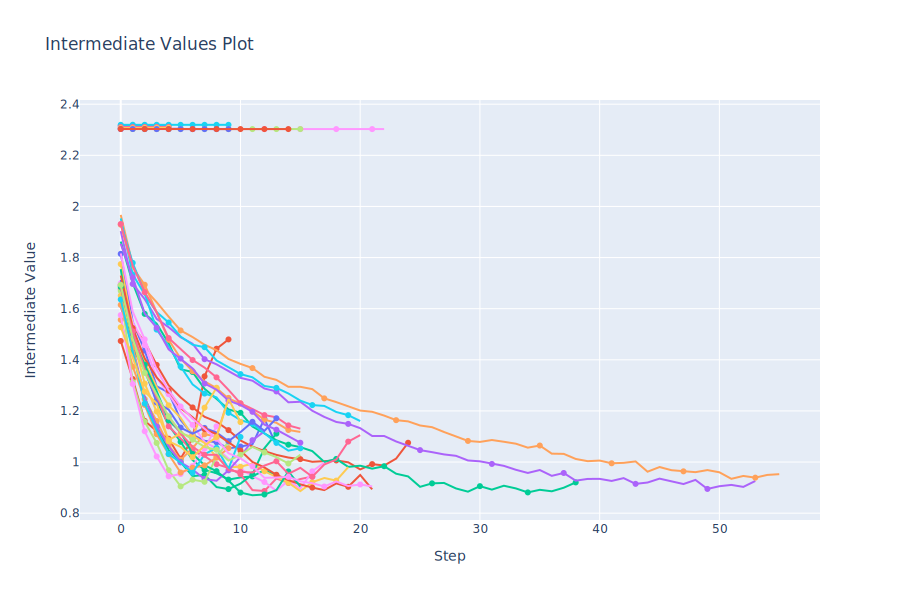

In [47]:
fig = optuna.visualization.plot_intermediate_values(study)
fig.update_layout(width=900, height=600)
fig.show(renderer="svg")

```{figure} ../../img/optuna-6.png
---
scale: 50%
name: optuna-6
---
```

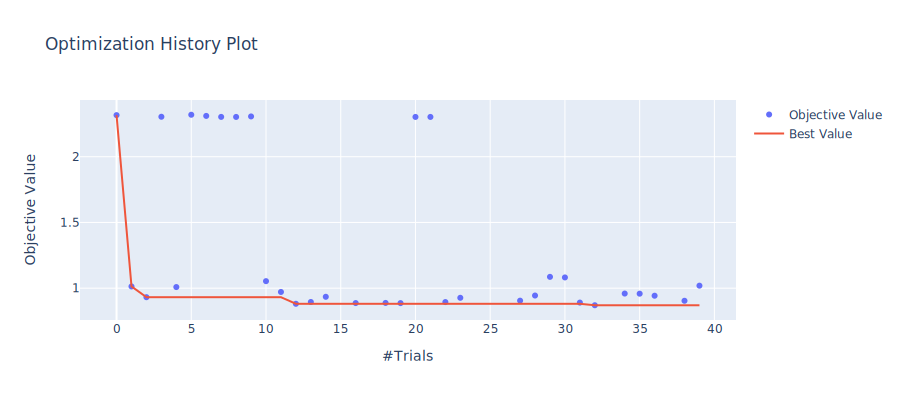

In [40]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=900, height=400)
fig.show(renderer="svg")

We can look at the distribution of best validation losses.

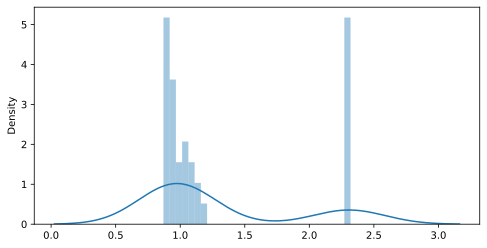

In [52]:
import seaborn as sns
plt.figure(figsize=(8, 4), dpi=80)
sns.distplot(study.trials_dataframe().value.values, bins=30);

### Hyperparameter interactions

The parallel coordinate plot below shows which combination of hyperparameters work. We can also use this to select low complexity models with similar performance to the best performance. 

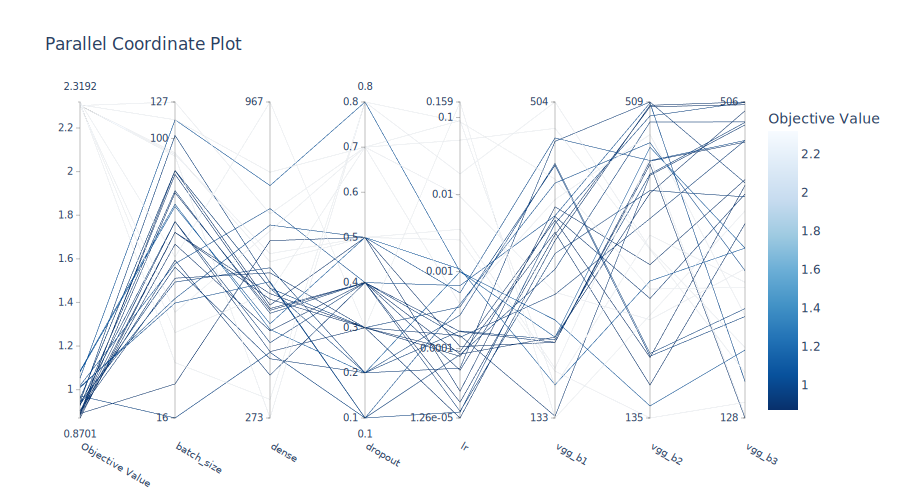

In [55]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=900, height=500)
fig.show(renderer="svg")

Slice plots can be used as guide to parameter ranges to search when making an updated study, i.e. re-running the experiment with tighter ranges. 

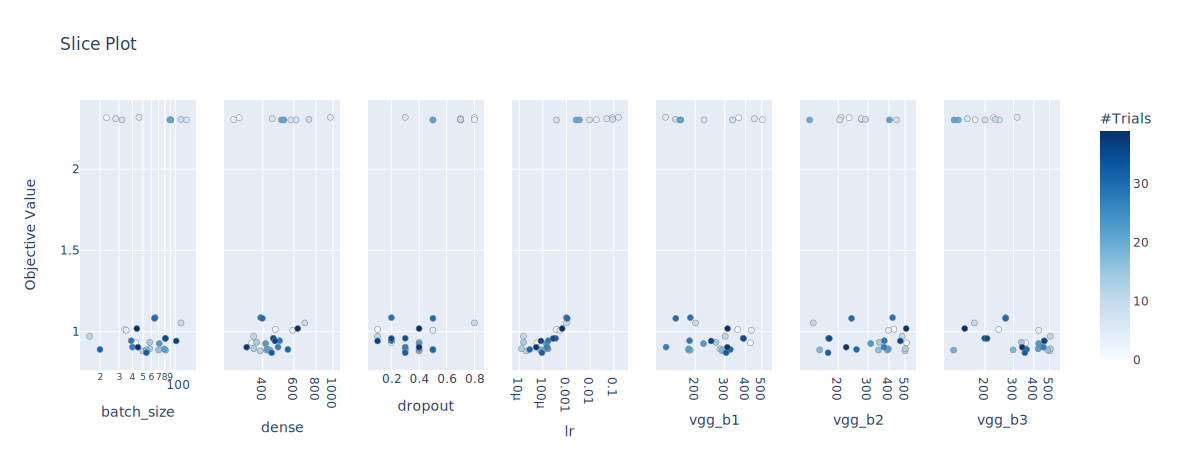

In [56]:
fig = optuna.visualization.plot_slice(study)
fig.update_layout(width=1200, height=450)
fig.show(renderer="svg")

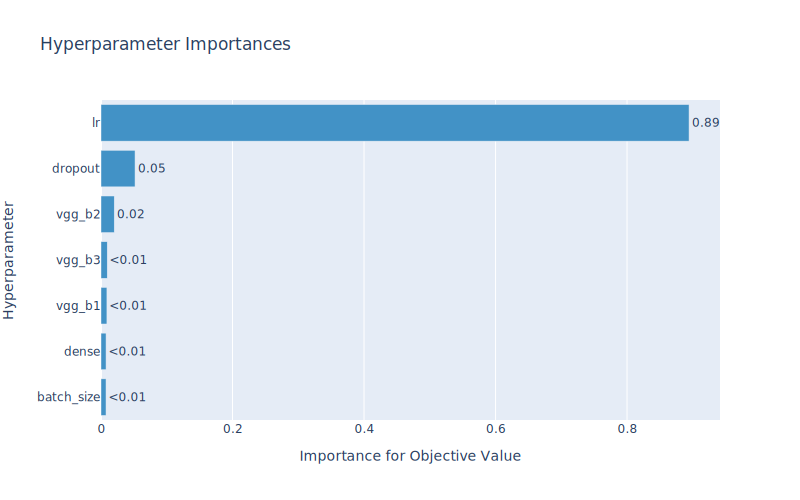

In [57]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(width=800, height=500)
fig.show(renderer="svg")

Turns out a low learning rate works for any size of the first VGG block and batch size.

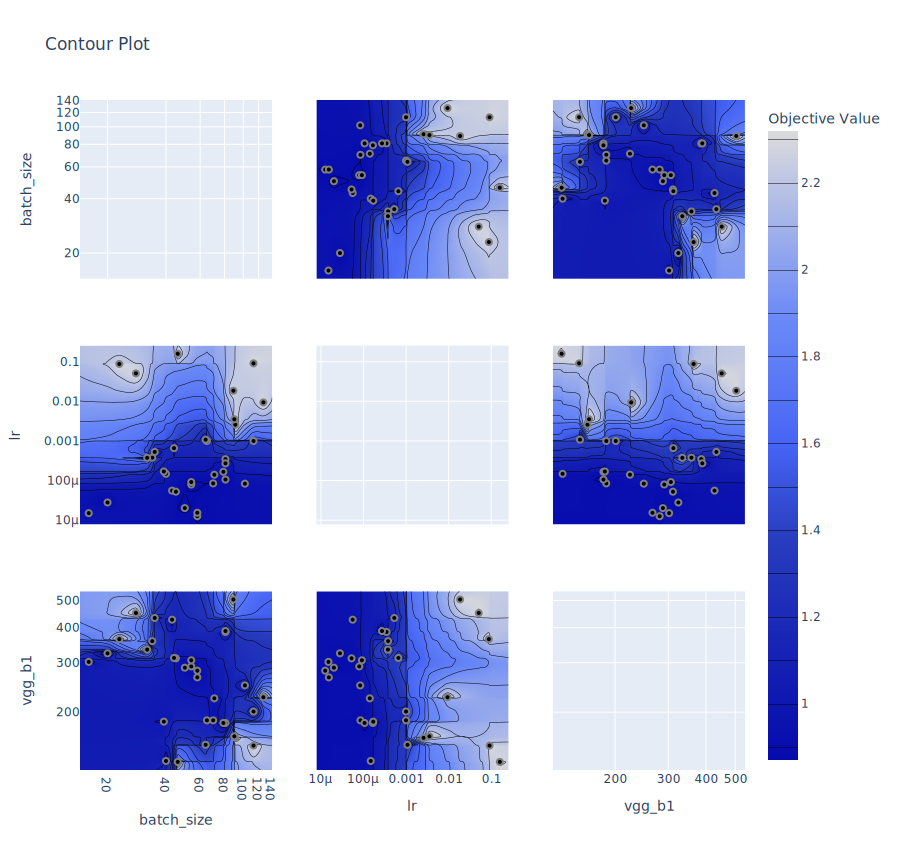

In [63]:
fig = optuna.visualization.plot_contour(study, params=['lr', 'batch_size', 'vgg_b1'])
fig.update_layout(autosize=False, width=900, height=850)
fig.show(renderer="svg")

For the bottom part of the network, a large width for the fully-connected block seems to work well. Meanwhile the size of the 3rd VGG block seem to be multimodal.

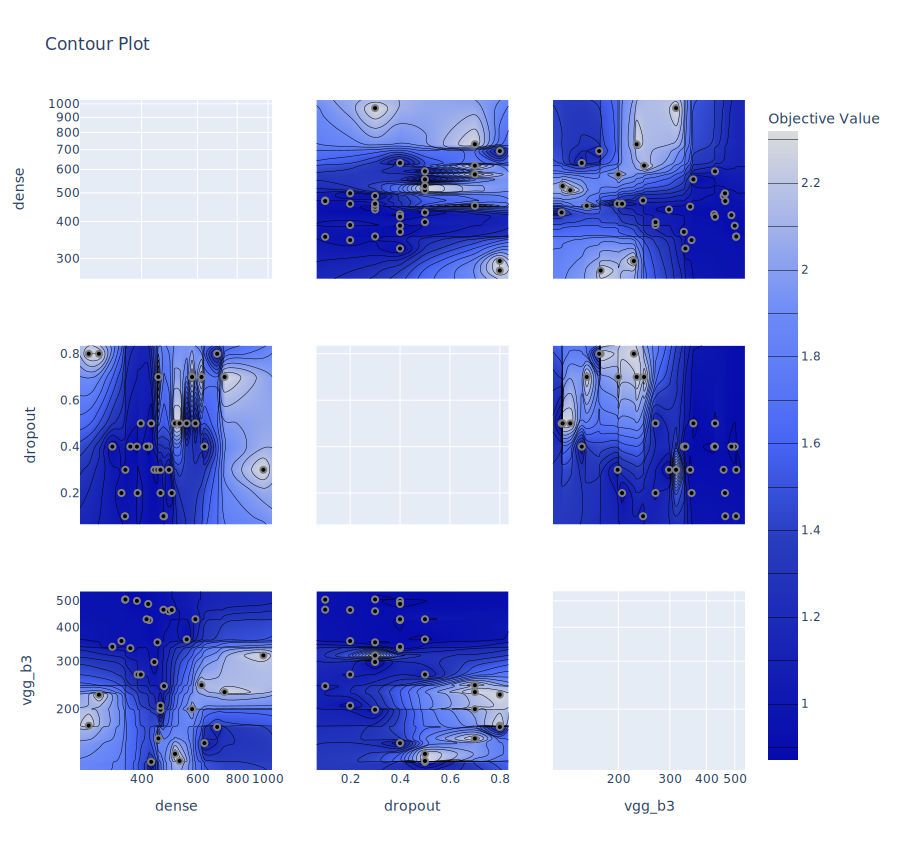

In [62]:
fig = optuna.visualization.plot_contour(study, params=['vgg_b3', 'dense', 'dropout'])
fig.update_layout(autosize=False, width=900, height=850)
fig.show(renderer='svg')

## Appendix: Hyperparameters of commonly used models

<br>

```{figure} ../../img/hyp.png
---
name: hyp
---
Table from p. 184 of {cite}`AAAMLP`. **RS**$^*$ implies random search should be better.
```

### XGBoost parameter space

The following search space is used to tune XGBoost in the [autoxgb](https://github.com/abhishekkrthakur/autoxgb) package:

```python
#https://github.com/abhishekkrthakur/autoxgb/blob/main/src/autoxgb/params.py
def get_params(trial, model_config):
    
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.25, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 100.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 100.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 100, 500),
        "n_estimators": trial.suggest_categorical("n_estimators", [7000, 15000, 20000]),
    }
    
    if model_config.use_gpu:
        params["tree_method"] = "gpu_hist"
        params["gpu_id"] = 0
        params["predictor"] = "gpu_predictor"
    else:
        params["tree_method"] = trial.suggest_categorical("tree_method", ["exact", "approx", "hist"])
        params["booster"] = trial.suggest_categorical("booster", ["gbtree", "gblinear"])
        if params["booster"] == "gbtree":
            params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    return params
```